# Extract stock data from Yahoo Finance

Here’s a full modular pipeline in Python that:

Downloads daily price data and resamples quarterly

Extracts key quarterly momentum features

Fetches quarterly fundamental and other features from yfinance

Handles missing data smartly

Creates a binary target variable (buy/sell) based on future returns

Returns a flat DataFrame ready for ML modeling



Function defitions:

* get_price_features: downloads daily data, resamples quarterly, computes returns, volatility, momentum.

* get_fundamental_features: grabs the latest fundamentals, institutional holdings, ESG, dividends, recommendations.

* build_quarterly_dataset: merges both, cleans missing values, creates a binary future return target.



#### TODO
* MACD calculation
* difference between OPEn and CLOSE prices and HIGh vs LOW
* add Macro params


In [128]:
#!pip install pandas_datareader

In [129]:
import yfinance as yf
import pandas_datareader as pdr

import pandas as pd
import numpy as np

from datetime import datetime
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
tickers = pd.read_csv('tickers.csv')
tickers.head()

,country,ticker,company,sector
0,USA,AAPL,Apple,IT
1,USA,MSFT,Microsoft,IT
2,USA,NVDA,NVIDIA,IT
3,USA,ORCL,Oracle,IT
4,USA,IBM,IBM,IT


In [131]:
tickers_stock = tickers['ticker'].tolist()
len(tickers_stock)

14

In [132]:
# Define the start and end dates for the data retrieval
start_date = '2000-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
end_date

'2025-06-07'

### 1. Fetch Closing price

In [133]:
def get_price_features(ticker, start, end): 
    """
    Download daily prices, resample quarterly, create momentum, volatility,
    and quarterly moving average features.
    """
    try:
        df = yf.Ticker(ticker).history(start=start, end=end, interval='1d')[['Close']]
        if df.empty:
            print(f"No price data for {ticker}")
            return pd.DataFrame()
        
        # Resample to quarter-end close price
        df = df.resample('QE').last()
        #historical growth rate
        df['return_1q'] = df['Close'].pct_change(1)
        df['return_2q'] = df['Close'].pct_change(2)
        df['return_3q'] = df['Close'].pct_change(3)
        df['return_4q'] = df['Close'].pct_change(4)
        df['vol_3q'] = df['Close'].pct_change().rolling(window=3).std()
        df['momentum_3q'] = df['return_3q'] / df['vol_3q']  # Sharpe proxy

        # quarterly moving averages
        df['qma_2'] = df['Close'].rolling(window=2).mean()
        df['qma_4'] = df['Close'].rolling(window=4).mean()
        df['qma_8'] = df['Close'].rolling(window=8).mean()

        # crossover signals (for modeling or visualizations)
        df['buy_signal'] = (df['qma_2'] > df['qma_4']) & (df['qma_2'].shift(1) <= df['qma_4'].shift(1))
        df['sell_signal'] = (df['qma_2'] < df['qma_4']) & (df['qma_2'].shift(1) >= df['qma_4'].shift(1))

        df = df.dropna()
        df.reset_index(inplace=True)

        # Convert to datetime and remove timezone
        df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

        # Extract year and quarter
        df['year'] = df['Date'].dt.year
        df['quarter'] = df['Date'].dt.quarter

        df['ticker'] = ticker
        return df

    except Exception as e:
        print(f"[PRICE] Error for {ticker}: {e}")
        return pd.DataFrame()


In [150]:
def get_price_features(ticker, start, end, features=True):
    """
    Download daily prices, resample quarterly ('QE'), and compute features:
    - Returns, volatility, momentum
    - Quarterly moving averages
    - Crossover signals
    If features=False, returns only raw quarterly Close data with metadata.
    """
    try:
        # Download data
        data = yf.Ticker(ticker).history(start=start, end=end, interval='1d')

        if data.empty:
            print(f"No price data for {ticker}")
            return pd.DataFrame()

        # Prefer Adj Close if available
        price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
        df = data[[price_col]].rename(columns={price_col: 'Close'})

        # Resample to quarter-end using 'QE'
        df = df.resample('QE').last()

        # Convert index to datetime, remove timezone
        df.index = pd.to_datetime(df.index).tz_localize(None)
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)

        if features:
            # Historical quarterly returns
            df['return_1q'] = df['Close'].pct_change(1)
            df['return_2q'] = df['Close'].pct_change(2)
            df['return_3q'] = df['Close'].pct_change(3)
            df['return_4q'] = df['Close'].pct_change(4)

            # Volatility & momentum
            df['vol_3q'] = df['Close'].pct_change().rolling(window=3).std()
            df['momentum_3q'] = df['return_3q'] / df['vol_3q']

            # Quarterly moving averages
            df['qma_2'] = df['Close'].rolling(window=2).mean()
            df['qma_4'] = df['Close'].rolling(window=4).mean()
            df['qma_8'] = df['Close'].rolling(window=8).mean()

            # Crossover signals
            df['buy_signal'] = (df['qma_2'] > df['qma_4']) & (df['qma_2'].shift(1) <= df['qma_4'].shift(1))
            df['sell_signal'] = (df['qma_2'] < df['qma_4']) & (df['qma_2'].shift(1) >= df['qma_4'].shift(1))

        # Add metadata
        df['year'] = df['Date'].dt.year
        df['quarter'] = df['Date'].dt.quarter
        df['ticker'] = ticker

        df = df.dropna().reset_index(drop=True)
        return df

    except Exception as e:
        print(f"[PRICE] Error for {ticker}: {e}")
        return pd.DataFrame()


In [151]:
def get_fundamental_features(ticker, end):
    """
    Fetch fundamental & metadata features from yfinance, return as dict.
    """
    try:
        tk = yf.Ticker(ticker)
        info = tk.get_info() or {}
        bs = tk.get_balance_sheet()
        cf = tk.get_cashflow()
        holders = tk.get_institutional_holders()
        sustainability = tk.get_sustainability()
        recommendations = tk.get_recommendations()
        calendar = tk.get_calendar()

        # Ensure to take the latest available data from balance sheet
        def safe_get_latest(bs_df, row_name):
            if bs_df is not None and row_name in bs_df.index:
                series = bs_df.loc[row_name].dropna()
                if not series.empty:
                    return series.iloc[0]
            return np.nan
 
        # Fundamental ratios

        # BS parameters
        total_assets = safe_get_latest(bs, 'TotalAssets')
        total_liabilities = safe_get_latest(bs, 'TotalLiabilitiesNetMinorityInterest')
        total_equity = safe_get_latest(bs, 'StockholdersEquity')
        long_term_debt = safe_get_latest(bs, 'LongTermDebt')
        current_assets = safe_get_latest(bs, 'CurrentAssets')
        current_liabilities = safe_get_latest(bs, 'CurrentLiabilities')
        cash_equivalents = safe_get_latest(bs, 'CashAndCashEquivalents')
        retained_earnings = safe_get_latest(bs, 'RetainedEarnings')
        working_capital = safe_get_latest(bs, 'WorkingCapital')

        debt_to_equity = total_liabilities / total_equity if total_equity else np.nan
        current_ratio = current_assets / current_liabilities if current_liabilities else np.nan
        cash_ratio = cash_equivalents / current_liabilities if current_liabilities else np.nan
        working_capital_ratio = working_capital / total_assets if total_assets else np.nan
        retained_earnings_to_assets = retained_earnings / total_assets if total_assets else np.nan
        long_term_debt_to_equity = long_term_debt / total_equity if total_equity else np.nan


        op_cf = cf.loc['OperatingCashFlow'].iloc[0] if cf is not None and 'OperatingCashFlow' in cf.index else None
        revenue = info.get('totalRevenue')
        operating_cf_margin = op_cf / revenue if op_cf and revenue else np.nan
        

        free_cf = cf.loc['FreeCashFlow'].iloc[0] if cf is not None and 'FreeCashFlow' in cf.index else None
        free_cf_margin = free_cf / revenue if free_cf and revenue else np.nan

        # Institutional holders
        pct_held = holders['pctHeld'].mean() if holders is not None and not holders.empty else np.nan
        inst_count = len(holders) if holders is not None else np.nan

        # ESG scores
        esg_env = sustainability.loc['environmentScore'].iloc[0] if sustainability is not None and 'environmentScore' in sustainability.index else np.nan
        esg_soc = sustainability.loc['socialScore'].iloc[0] if sustainability is not None and 'socialScore' in sustainability.index else np.nan
        esg_gov = sustainability.loc['governanceScore'].iloc[0] if sustainability is not None and 'governanceScore' in sustainability.index else np.nan

        # Recommendations count last 90 days
        recent_reco = 0
        if recommendations is not None and not recommendations.empty:
            recent_months = recommendations[recommendations['period'].isin(['0m', '-1m', '-2m', '-3m'])]
            recent_reco = recent_months[['strongBuy', 'buy', 'hold', 'sell', 'strongSell']].sum().sum()
            strong_to_total_ratio = recent_months['strongBuy'].sum() / recent_reco if recent_reco else np.nan

        # Days to next earnings
        days_to_earnings = np.nan
        if calendar and isinstance(calendar, dict) and 'Earnings Date' in calendar:
            earnings_dates = calendar['Earnings Date']
            if isinstance(earnings_dates, list) and len(earnings_dates) > 0:
                earnings_date = earnings_dates[0]
                if isinstance(earnings_date, (datetime.date, datetime.datetime)):
                    earnings_datetime = pd.to_datetime(earnings_date)
                    days_to_earnings = (earnings_datetime - pd.to_datetime(end)).days
        
        # Dividend stability: std of yearly dividend sums / mean dividend sums
        actions = tk.get_actions()
        dividend_stability = np.nan
        if actions is not None and 'Dividends' in actions.columns:
            yearly_divs = actions['Dividends'].resample('YE').sum()
            if len(yearly_divs) > 1 and yearly_divs.mean() != 0:
                dividend_stability = yearly_divs.std() / yearly_divs.mean()

        return {
            'marketCap': info.get('marketCap', np.nan),
            'beta': info.get('beta', np.nan),
            'trailingPE': info.get('trailingPE', np.nan),
            'forwardPE': info.get('forwardPE', np.nan),
            'trailing_PEG': info.get('trailingPegRatio', np.nan),
            'priceToBook': info.get('priceToBook', np.nan),
            'dividendYield': info.get('dividendYield', np.nan),
            'debt_to_equity': debt_to_equity,
            'debt_to_equity': debt_to_equity,
            'current_ratio': current_ratio,
            'cash_ratio': cash_ratio,
            'working_capital': working_capital,
            'working_capital_ratio': working_capital_ratio,
            'retained_earnings_to_assets': retained_earnings_to_assets,
            'long_term_debt_to_equity': long_term_debt_to_equity,
            'operating_cf_margin': operating_cf_margin,
            'free_cf_margin': free_cf_margin,
            'pct_held_by_inst': pct_held,
            'institutional_holders_count': inst_count,
            'esg_env': esg_env,
            'esg_soc': esg_soc,
            'esg_gov': esg_gov,
            'recent_rating_changes': recent_reco,
            'strong_to_total_reco_ratio': strong_to_total_ratio,
            'days_to_next_earnings': days_to_earnings,
            'dividend_stability': dividend_stability,
            'companyName': info.get('shortName', np.nan),
            'sector': info.get('sector'),
            'industry': info.get('industry'),
            'country': info.get('country'),
            'fullTimeEmployees': info.get('fullTimeEmployees', np.nan),
        }
    except Exception as e:
        print(f"[FUNDAMENTAL] Error for {ticker}: {e}")
        return {}


In [152]:
def build_quarterly_dataset(tickers, start_date, end_date):
    """
    Build full feature dataset for ML training:
    - Quarterly price momentum & volatility features
    - Latest fundamental features (same for all quarters)
    - Target variable: future quarter return median split
    """
    all_rows = []
    for ticker in tickers:
        print(f"Processing {ticker}")
        price_df = get_price_features(ticker, start_date, end_date)
        if price_df.empty:
            print(f"No price data for {ticker}, skipping")
            continue
        fund_feats = get_fundamental_features(ticker, end_date)
        if not fund_feats:
            print(f"No fundamental data for {ticker}, skipping")
            continue
        # Merge features
        for idx, row in price_df.iterrows():
            data = {
                'ticker': ticker,
                'date': row['Date'],
                'year': row['year'],
                'quarter': row['quarter'],
                'close': row['Close'],
                'return_1q': row['return_1q'],
                'return_2q': row['return_2q'],
                'return_3q': row['return_3q'],
                'vol_3q': row['vol_3q'],
                'momentum_3q': row['momentum_3q'],
                'qma_2': row['qma_2'],
                'qma_4': row['qma_4'],
                'qma_8': row['qma_8'],
                'buy_signal': row['buy_signal'],
                'sell_signal': row['sell_signal']
            }
            data.update(fund_feats)
            all_rows.append(data)

    df = pd.DataFrame(all_rows)

    # Target: future quarter return > median -> 1 else 0
    #df = df.sort_values(['ticker', 'date'])
    #df['future_return'] = df.groupby('ticker')['close'].shift(-1) / df['close'] - 1
    #median_return = df['future_return'].median()
    #df['target'] = (df['future_return'] > median_return).astype(int)
    #df = df.drop(columns=['future_return'])
    return df


## Get Stock data

In [153]:
df = build_quarterly_dataset(tickers_stock, start_date, end_date)
df.head()

Processing AAPL
Processing MSFT
Processing NVDA
Processing ORCL
Processing IBM
Processing JNJ
Processing PFE
Processing MRK
Processing ABBV
Processing UNH
Processing SAP.DE
Processing IFX.DE
Processing FME.DE
Processing SHL.DE


,ticker,date,year,quarter,close,return_1q,return_2q,return_3q,vol_3q,momentum_3q,...,esg_gov,recent_rating_changes,strong_to_total_reco_ratio,days_to_next_earnings,dividend_stability,companyName,sector,industry,country,fullTimeEmployees
0,AAPL,2001-12-31,2001,4,0.329093,0.411992,-0.058067,-0.007704,0.372535,-0.020680,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
1,AAPL,2002-03-31,2002,1,0.355692,0.080824,0.526115,0.018064,0.373210,0.048402,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
2,AAPL,2002-06-30,2002,2,0.266280,-0.251373,-0.190865,0.142491,0.331682,0.429602,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
3,AAPL,2002-09-30,2002,3,0.217893,-0.181715,-0.387410,-0.337898,0.175183,-1.928828,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
4,AAPL,2002-12-31,2002,4,0.215338,-0.011725,-0.191310,-0.394593,0.123274,-3.200926,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000


In [154]:
df.shape

(1205, 45)

## Get Macro data

Core Macros (FRED)
GDPC1 (US GDP)

CPIAUCSL (US CPI)

FEDFUNDS (US rate)

UNRATE (US unemployment)

DEUCPIALLMINMEI (Germany CPI)

CLVMNACSCAB1GQDE (Germany GDP)

Core Market (yfinance)
^GSPC (S&P 500)

^VIX (Volatility Index)

^DAX (Germany)

SPY (ETF proxy for S&P)

GLD (Gold proxy)

VGK (Europe ETF)



### 1.  FRED Macroeconomic Indicators



In [155]:
def get_fred_macro_data(fred_series, start_date, end_date):
    """
    Fetch FRED macroeconomic data, compute YoY and QoQ changes,
    and return a single merged DataFrame resampled to quarter-end.

    Parameters:
    - fred_series: dict of {friendly_name: FRED_series_code}
    - start_date, end_date: date strings in 'YYYY-MM-DD' format

    Returns:
    - macro_df: DataFrame with macro features per quarter
    """
    fred_data = {}

    for name, code in fred_series.items():
        try:
            df = pdr.DataReader(code, "fred", start=start_date, end=end_date)
            if df.empty:
                print(f"[FRED] No data for {name} ({code}), skipping.")
                continue
            # YoY and QoQ percentage changes
            df[name + '_yoy'] = df[code].pct_change(4)
            df[name + '_qoq'] = df[code].pct_change(1)

            # Rename column to friendly name
            df = df.rename(columns={code: name})

            fred_data[name] = df

        except Exception as e:
            print(f"[FRED] Error for {name} ({code}): {e}")
            continue

    if not fred_data:
        print("No FRED data retrieved.")
        return pd.DataFrame()

    # Merge and resample to quarter-end
    macro_df = pd.concat(fred_data.values(), axis=1).resample('QE').last()
    

    # Extract year and quarter for joining with other datasets
    macro_df = macro_df.reset_index()
    macro_df['year'] = macro_df['DATE'].dt.year
    macro_df['quarter'] = macro_df['DATE'].dt.quarter
    macro_df = macro_df.rename(columns={'DATE': 'date'})
    return macro_df


In [156]:
fred_series = {
    'gdp_us': 'GDPC1',
    'cpi_us': 'CPIAUCSL',
    'unemployment_us': 'UNRATE',
    'interest_us': 'FEDFUNDS',
    'gdp_de': 'CLVMNACSCAB1GQDE',
    'cpi_de': 'DEUCPIALLMINMEI',
    'interest_eu': 'IRLTLT01EZM156N'
}

In [141]:
macro_df = get_fred_macro_data(fred_series, start_date, end_date)
macro_df.head()

,date,gdp_us,gdp_us_yoy,gdp_us_qoq,cpi_us,cpi_us_yoy,cpi_us_qoq,unemployment_us,unemployment_us_yoy,unemployment_us_qoq,...,gdp_de_yoy,gdp_de_qoq,cpi_de,cpi_de_yoy,cpi_de_qoq,interest_eu,interest_eu_yoy,interest_eu_qoq,year,quarter
0,2000-03-31,13878.147,NaN,NaN,171.0,NaN,0.005882,4.0,NaN,-0.02439,...,NaN,NaN,79.57813,NaN,0.000000,5.490629,NaN,-0.030541,2000,1
1,2000-06-30,14130.908,NaN,0.018213,172.2,0.012941,0.005841,4.0,-0.024390,0.00000,...,NaN,0.007732,79.85801,0.003517,0.004695,5.345375,-0.056188,-0.030844,2000,2
2,2000-09-30,14145.312,NaN,0.001019,173.6,0.014019,0.005211,3.9,-0.025000,-0.04878,...,NaN,0.000609,80.23118,0.009390,0.002331,5.467185,-0.008759,0.012783,2000,3
3,2000-12-31,14229.765,NaN,0.005970,174.6,0.011002,0.002296,3.9,-0.048780,0.00000,...,NaN,-0.004260,80.88422,0.010490,0.008139,5.068026,-0.061160,-0.050167,2000,4
4,2001-03-31,14183.120,0.021975,-0.003278,176.1,0.010907,0.000568,4.3,0.102564,0.02381,...,0.025681,0.021544,81.07080,0.010465,0.000000,4.938122,-0.074513,-0.016520,2001,1


### 2. yfinance Market & ETFs

In [142]:
def get_macro_features(ticker_list, start, end):
    """
    Download macro ETF/index data from yfinance, resample quarterly,
    and compute simple moving average features.
    
    Parameters:
    - ticker_list: dict of {feature_name: yfinance_ticker}
    - start: start date string (e.g. '2000-01-01')
    - end: end date string
    
    Returns:
    - DataFrame with quarterly macro features (merged by Date)
    """
    macro_frames = []

    for name, code in ticker_list.items():
        try:
            data = yf.Ticker(code).history(start=start, end=end, interval='1d')
            if data.empty:
                print(f"No data for {code}, skipping.")
                continue

            price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
            df = data[[price_col]].rename(columns={price_col: 'Close'})

            # Resample to quarter-end
            df = df.resample('QE').last()
            df.index = pd.to_datetime(df.index).tz_localize(None)
            df.reset_index(inplace=True)

            # YoY and QoQ percentage changes
            df[name + '_yoy'] = df['Close'].pct_change(4)
            df[name + '_qoq'] = df['Close'].pct_change(1)
            df = df.rename(columns={'Close': name})

            #df = df[['Date', name + '_yoy', name + '_qoq']]
            macro_frames.append(df)

        except Exception as e:
            print(f"[ERROR] {name} ({code}): {e}")
            continue

    if not macro_frames:
        print("No macro features collected.")
        return pd.DataFrame()

    # Merge all on Date
    from functools import reduce
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), macro_frames)
    merged_df['year'] = merged_df['Date'].dt.year
    merged_df['quarter'] = merged_df['Date'].dt.quarter
    merged_df = merged_df.rename(columns={'Date': 'date'})

    return merged_df


In [143]:
tickers_macro = {
    'sp500': '^GSPC',
    'vix': '^VIX',
    'dax': '^GDAXI',
    'spy': 'SPY',
    'gld': 'GLD',
    'vgk': 'VGK',
    'xlv': 'XLV',    # Healthcare
    'xlk': 'XLK',    # Tech
    'xlf': 'XLF',    # Financials
    'efa': 'EFA',    # Developed markets
    'eurusd': 'EURUSD=X',   # Euro to USD
    'usdx': 'DX-Y.NYB'      # Dollar Index
}

In [144]:
df_macro_yf = get_macro_features(tickers_macro, start_date, end_date)
df_macro_yf.head()

,date,sp500,sp500_yoy,sp500_qoq,vix,vix_yoy,vix_qoq,dax,dax_yoy,dax_qoq,...,efa_yoy,efa_qoq,eurusd,eurusd_yoy,eurusd_qoq,usdx,usdx_yoy,usdx_qoq,year,quarter
0,2000-03-31,1498.579956,NaN,NaN,24.110001,NaN,NaN,7599.390137,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,105.440002,NaN,NaN,2000,1
1,2000-06-30,1454.599976,NaN,-0.029348,19.540001,NaN,-0.189548,6898.209961,NaN,-0.092268,...,NaN,NaN,NaN,NaN,NaN,106.839996,NaN,0.013278,2000,2
2,2000-09-30,1436.510010,NaN,-0.012436,20.570000,NaN,0.052712,6798.120117,NaN,-0.014510,...,NaN,NaN,NaN,NaN,NaN,113.250000,NaN,0.059996,2000,3
3,2000-12-31,1320.280029,NaN,-0.080911,26.850000,NaN,0.305299,6433.609863,NaN,-0.053619,...,NaN,NaN,NaN,NaN,NaN,109.559998,NaN,-0.032583,2000,4
4,2001-03-31,1160.329956,-0.225714,-0.121149,28.639999,0.187889,0.066667,5829.950195,-0.23284,-0.093829,...,NaN,NaN,NaN,NaN,NaN,117.370003,0.113145,0.071285,2001,1


In [145]:
macro_df.shape

(102, 24)

In [146]:
df_macro_yf.shape

(102, 39)

## Merge stock data with macro data: N-to-1 relationship 

In [157]:
df.shape

(1205, 45)

In [158]:
df#'date'].nunique()

,ticker,date,year,quarter,close,return_1q,return_2q,return_3q,vol_3q,momentum_3q,...,esg_gov,recent_rating_changes,strong_to_total_reco_ratio,days_to_next_earnings,dividend_stability,companyName,sector,industry,country,fullTimeEmployees
0,AAPL,2001-12-31,2001,4,0.329093,0.411992,-0.058067,-0.007704,0.372535,-0.020680,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
1,AAPL,2002-03-31,2002,1,0.355692,0.080824,0.526115,0.018064,0.373210,0.048402,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
2,AAPL,2002-06-30,2002,2,0.266280,-0.251373,-0.190865,0.142491,0.331682,0.429602,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
3,AAPL,2002-09-30,2002,3,0.217893,-0.181715,-0.387410,-0.337898,0.175183,-1.928828,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
4,AAPL,2002-12-31,2002,4,0.215338,-0.011725,-0.191310,-0.394593,0.123274,-3.200926,...,8.58,185,0.145946,53,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,SHL.DE,2024-06-30,2024,2,52.909893,-0.033542,0.042158,0.142032,0.070189,2.023562,...,6.92,76,0.315789,53,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1201,SHL.DE,2024-09-30,2024,3,52.968899,0.001115,-0.032464,0.043320,0.057267,0.756459,...,6.92,76,0.315789,53,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1202,SHL.DE,2024-12-31,2024,4,51.238018,-0.032677,-0.031599,-0.064080,0.019764,-3.242216,...,6.92,76,0.315789,53,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1203,SHL.DE,2025-03-31,2025,1,49.610001,-0.031774,-0.063413,-0.062368,0.019255,-3.239139,...,6.92,76,0.315789,53,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000


In [ ]:
data_m1 = pd.merge(df, macro_df, how='left',
                   on=['date', 'year', 'quarter'],
                   validate = "many_to_one"
                   )
data_m1.shape

In [161]:
data_m2 = pd.merge(data_m1, df_macro_yf, how='left',
                   on=['date', 'year', 'quarter'],
                   validate = "many_to_one"
                   )
data_m2.shape

(1205, 102)

In [162]:
data_m2.columns

Index(['ticker', 'date', 'year', 'quarter', 'close', 'return_1q', 'return_2q',
       'return_3q', 'vol_3q', 'momentum_3q',
       ...
       'xlf_qoq', 'efa', 'efa_yoy', 'efa_qoq', 'eurusd', 'eurusd_yoy',
       'eurusd_qoq', 'usdx', 'usdx_yoy', 'usdx_qoq'],
      dtype='object', length=102)

# EDA Visualization

### 1. Stock Price over the time

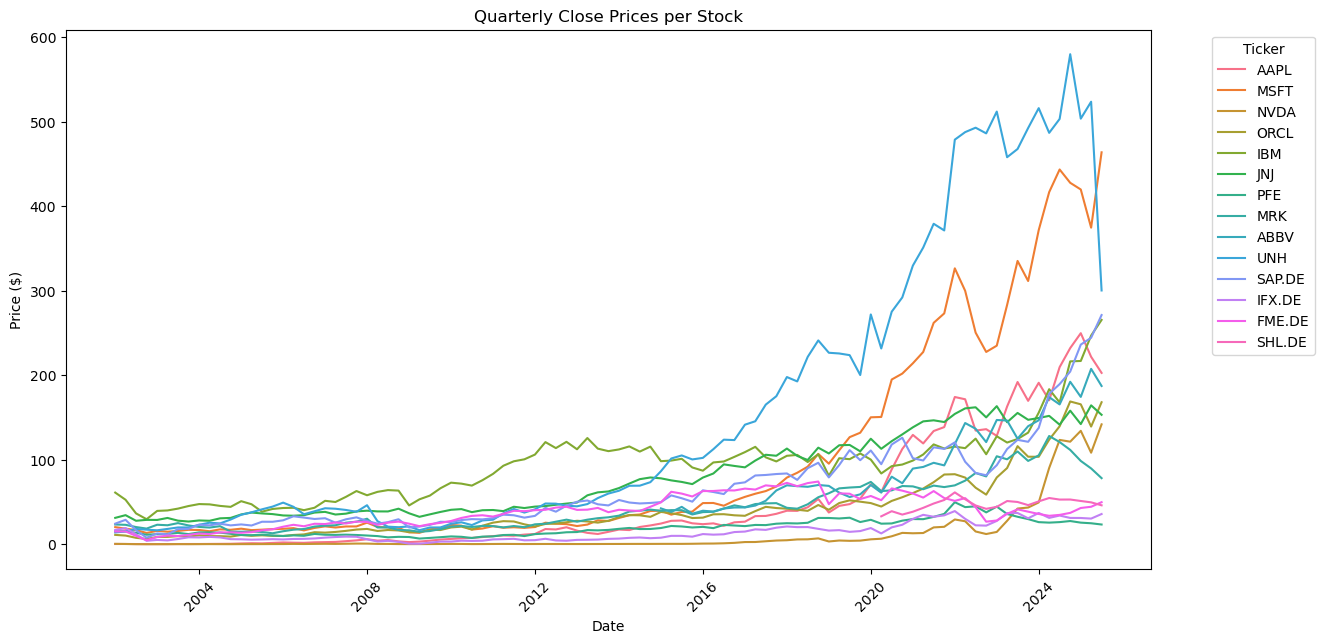

In [221]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='date', y='close', hue='ticker')
plt.title("Quarterly Close Prices per Stock")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')

### 2. Missing data heatmap

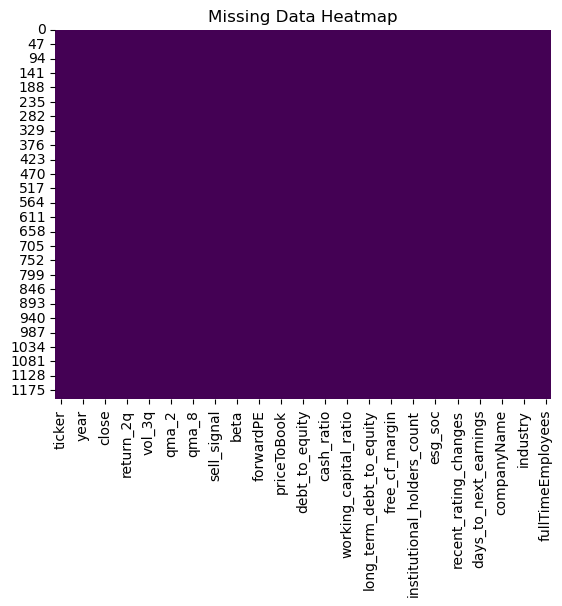

In [222]:
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

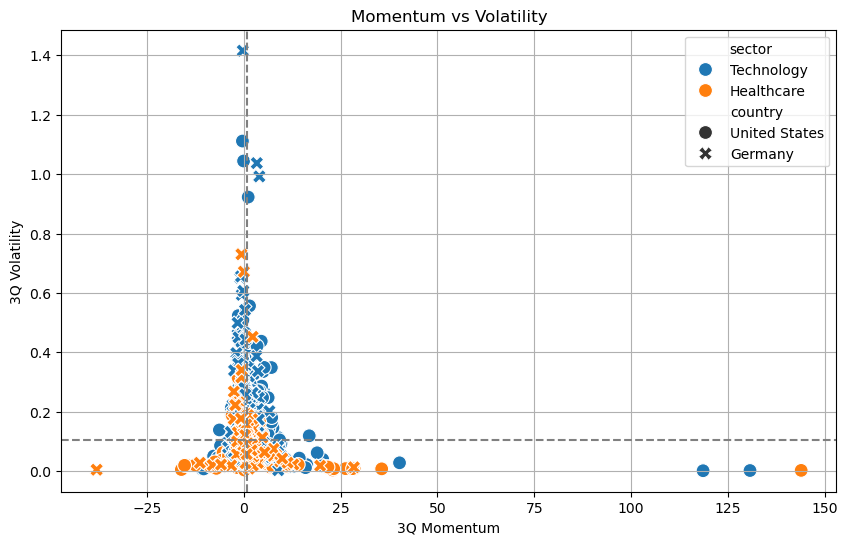

In [223]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='momentum_3q', y='vol_3q', hue='sector', style='country', s=100)
plt.axhline(df['vol_3q'].median(), linestyle='--', color='grey')
plt.axvline(df['momentum_3q'].median(), linestyle='--', color='grey')
plt.title('Momentum vs Volatility')
plt.xlabel('3Q Momentum')
plt.ylabel('3Q Volatility')
plt.grid(True)
plt.show()

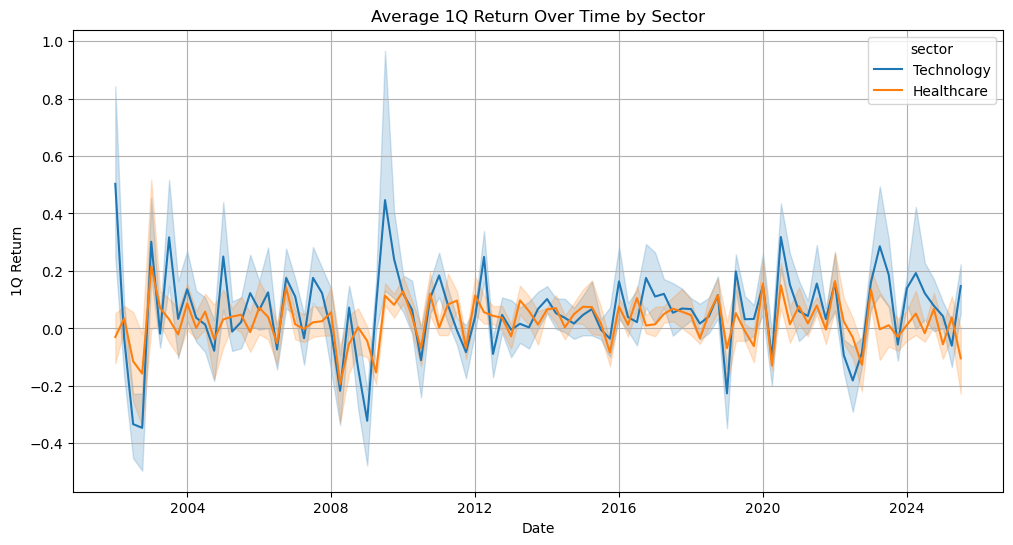

In [224]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='return_1q', hue='sector', estimator='mean')
plt.title('Average 1Q Return Over Time by Sector')
plt.ylabel('1Q Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()

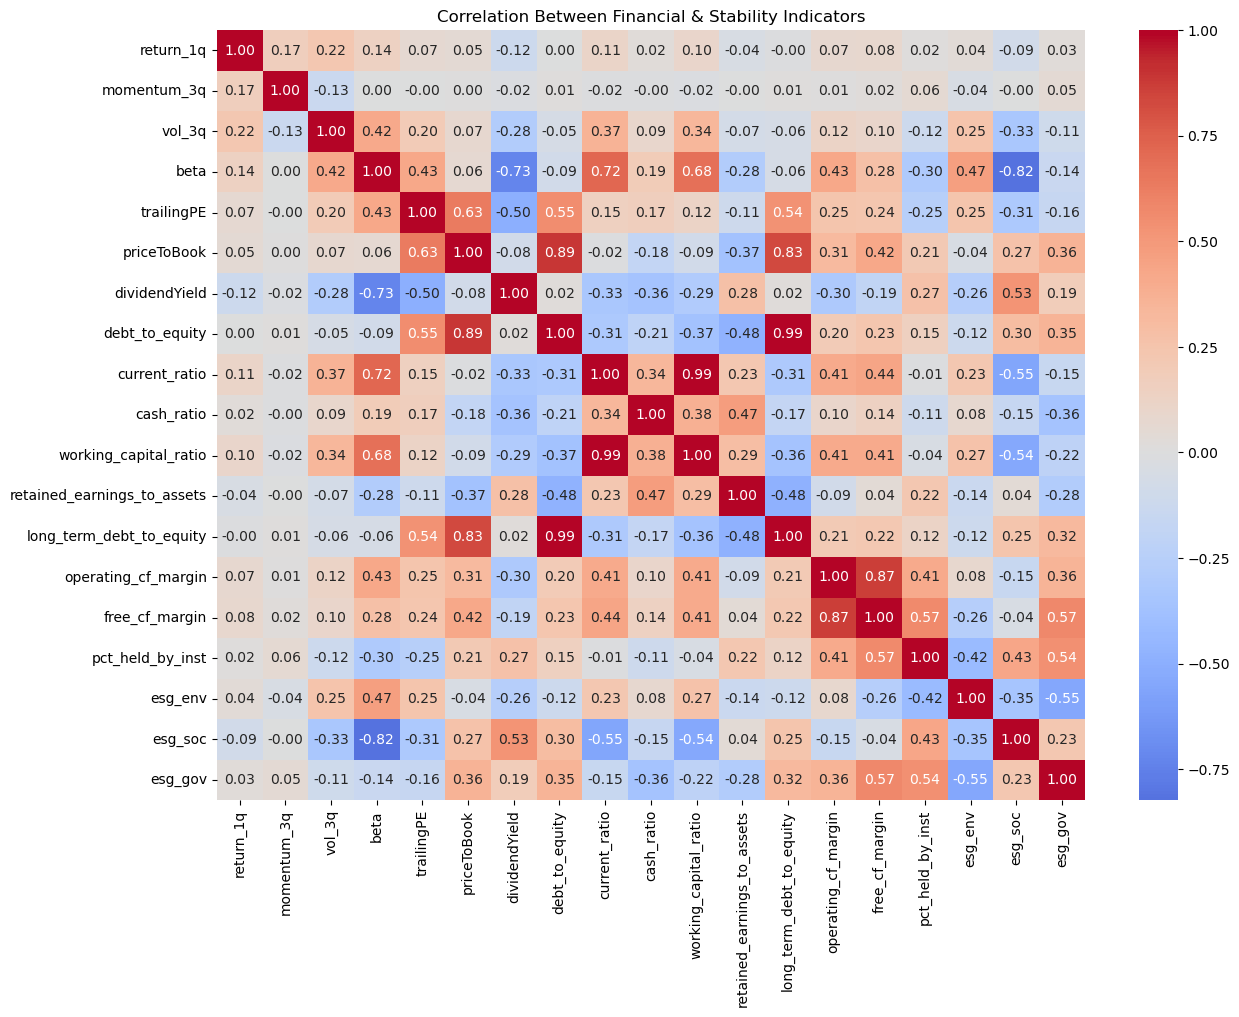

In [225]:
numeric_cols = [
    'return_1q', 'momentum_3q', 'vol_3q',
    'beta', 'trailingPE', 'priceToBook', 'dividendYield',
    'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital_ratio',
    'retained_earnings_to_assets', 'long_term_debt_to_equity',
    'operating_cf_margin', 'free_cf_margin', 'pct_held_by_inst',
    'esg_env', 'esg_soc', 'esg_gov'
]

plt.figure(figsize=(14, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Between Financial & Stability Indicators")
plt.show()

In [226]:
df.columns

Index(['ticker', 'date', 'year', 'quarter', 'close', 'return_1q', 'return_2q',
       'return_3q', 'vol_3q', 'momentum_3q', 'qma_2', 'qma_4', 'qma_8',
       'buy_signal', 'sell_signal', 'marketCap', 'beta', 'trailingPE',
       'forwardPE', 'trailing_PEG', 'priceToBook', 'dividendYield',
       'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'strong_to_total_reco_ratio',
       'days_to_next_earnings', 'dividend_stability', 'companyName', 'sector',
       'industry', 'country', 'fullTimeEmployees'],
      dtype='object')

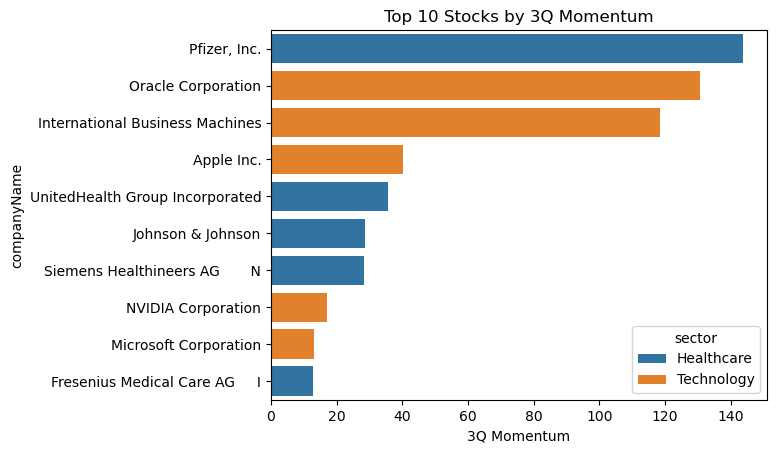

In [227]:
top_momentum = df.sort_values('momentum_3q', ascending=False).drop_duplicates('ticker').head(10)
sns.barplot(data=top_momentum, x='momentum_3q', y='companyName', hue='sector')
plt.title('Top 10 Stocks by 3Q Momentum')
plt.xlabel('3Q Momentum')
plt.ylabel('companyName')
plt.show()

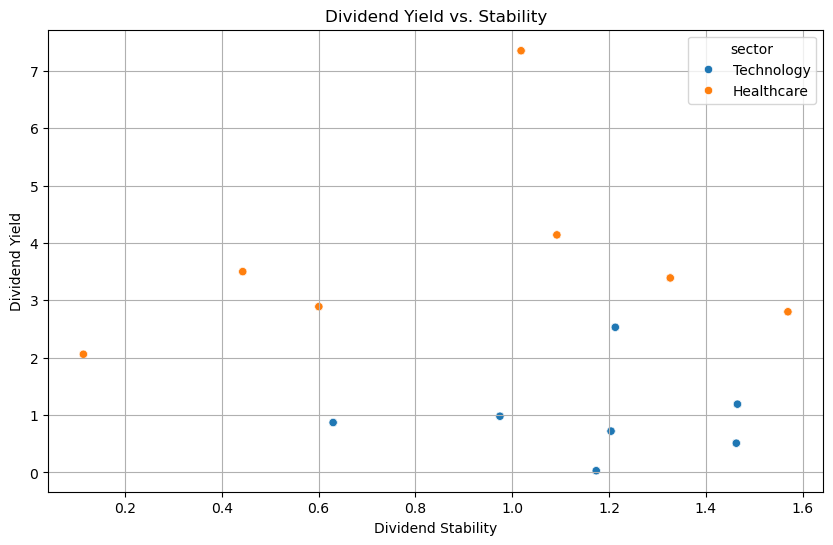

In [228]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='dividend_stability', y='dividendYield', hue='sector')
plt.title('Dividend Yield vs. Stability')
plt.xlabel('Dividend Stability')
plt.ylabel('Dividend Yield')
plt.grid(True)
plt.show()

In [229]:
df

,ticker,date,year,quarter,close,return_1q,return_2q,return_3q,vol_3q,momentum_3q,...,esg_gov,recent_rating_changes,strong_to_total_reco_ratio,days_to_next_earnings,dividend_stability,companyName,sector,industry,country,fullTimeEmployees
0,AAPL,2001-12-31,2001,4,0.329093,0.411991,-0.058067,-0.007704,0.372535,-0.020679,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
1,AAPL,2002-03-31,2002,1,0.355692,0.080824,0.526115,0.018064,0.373210,0.048402,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
2,AAPL,2002-06-30,2002,2,0.266280,-0.251373,-0.190866,0.142491,0.331682,0.429599,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
3,AAPL,2002-09-30,2002,3,0.217893,-0.181715,-0.387410,-0.337898,0.175183,-1.928829,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
4,AAPL,2002-12-31,2002,4,0.215338,-0.011725,-0.191310,-0.394593,0.123275,-3.200925,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,SHL.DE,2024-06-30,2024,2,52.909893,-0.033542,0.042158,0.142032,0.070189,2.023563,...,6.92,76,0.315789,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1201,SHL.DE,2024-09-30,2024,3,52.968899,0.001115,-0.032464,0.043320,0.057267,0.756459,...,6.92,76,0.315789,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1202,SHL.DE,2024-12-31,2024,4,51.238018,-0.032677,-0.031599,-0.064080,0.019764,-3.242216,...,6.92,76,0.315789,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1203,SHL.DE,2025-03-31,2025,1,49.610001,-0.031774,-0.063413,-0.062368,0.019255,-3.239139,...,6.92,76,0.315789,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000


In [230]:
df.columns

Index(['ticker', 'date', 'year', 'quarter', 'close', 'return_1q', 'return_2q',
       'return_3q', 'vol_3q', 'momentum_3q', 'qma_2', 'qma_4', 'qma_8',
       'buy_signal', 'sell_signal', 'marketCap', 'beta', 'trailingPE',
       'forwardPE', 'trailing_PEG', 'priceToBook', 'dividendYield',
       'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'strong_to_total_reco_ratio',
       'days_to_next_earnings', 'dividend_stability', 'companyName', 'sector',
       'industry', 'country', 'fullTimeEmployees'],
      dtype='object')

In [231]:
def plot_price_with_qma_signals(df, ticker):
    stock = df[df['ticker'] == ticker].copy()
    
    plt.figure(figsize=(14, 6))
    plt.plot(stock['date'], stock['close'], label='close', linewidth=2)
    plt.plot(stock['date'], stock['qma_2'], label='QMA2', linestyle='--')
    plt.plot(stock['date'], stock['qma_4'], label='QMA4', linestyle='--')
    plt.plot(stock['date'], stock['qma_8'], label='QMA8', linestyle=':')

    # Mark Buy/Sell signals
    plt.scatter(stock.loc[stock['buy_signal'], 'date'], 
                stock.loc[stock['buy_signal'], 'close'],
                marker='^', color='green', label='Buy Signal', zorder=5)
    plt.scatter(stock.loc[stock['sell_signal'], 'date'], 
                stock.loc[stock['sell_signal'], 'close'],
                marker='v', color='red', label='Sell Signal', zorder=5)

    plt.title(f'{df[df['ticker'] == ticker]['companyName'].values[0]}: Price with Quarterly Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [232]:
df.columns

Index(['ticker', 'date', 'year', 'quarter', 'close', 'return_1q', 'return_2q',
       'return_3q', 'vol_3q', 'momentum_3q', 'qma_2', 'qma_4', 'qma_8',
       'buy_signal', 'sell_signal', 'marketCap', 'beta', 'trailingPE',
       'forwardPE', 'trailing_PEG', 'priceToBook', 'dividendYield',
       'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'strong_to_total_reco_ratio',
       'days_to_next_earnings', 'dividend_stability', 'companyName', 'sector',
       'industry', 'country', 'fullTimeEmployees'],
      dtype='object')

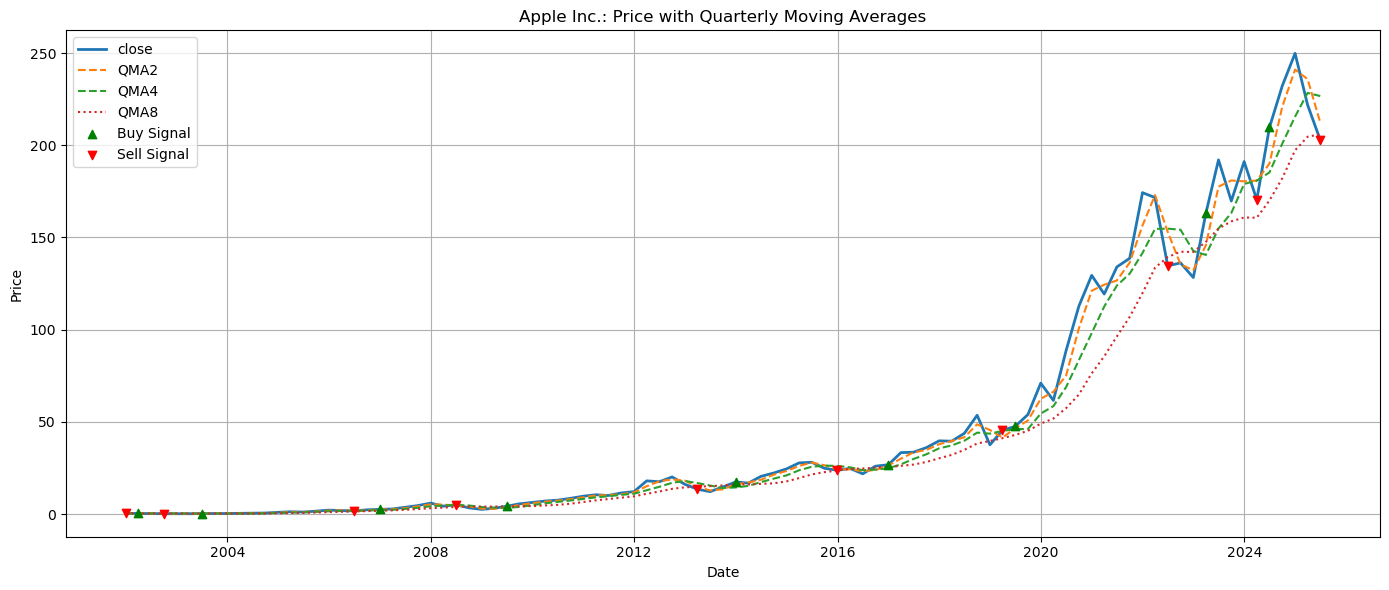

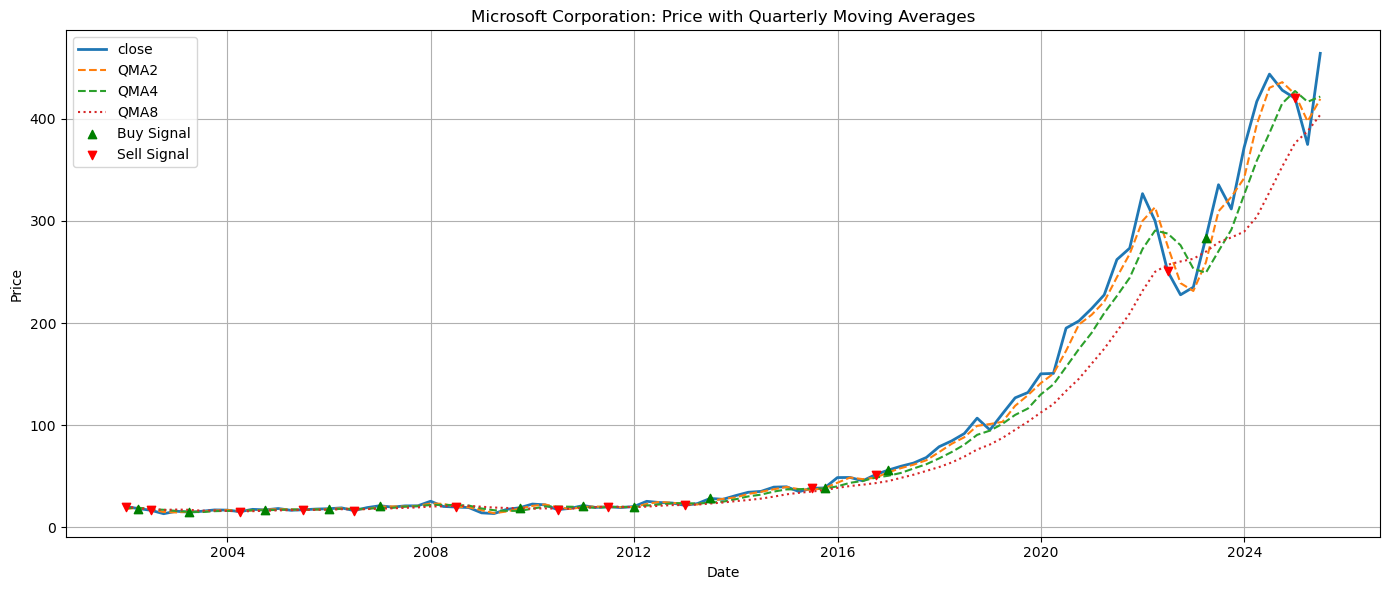

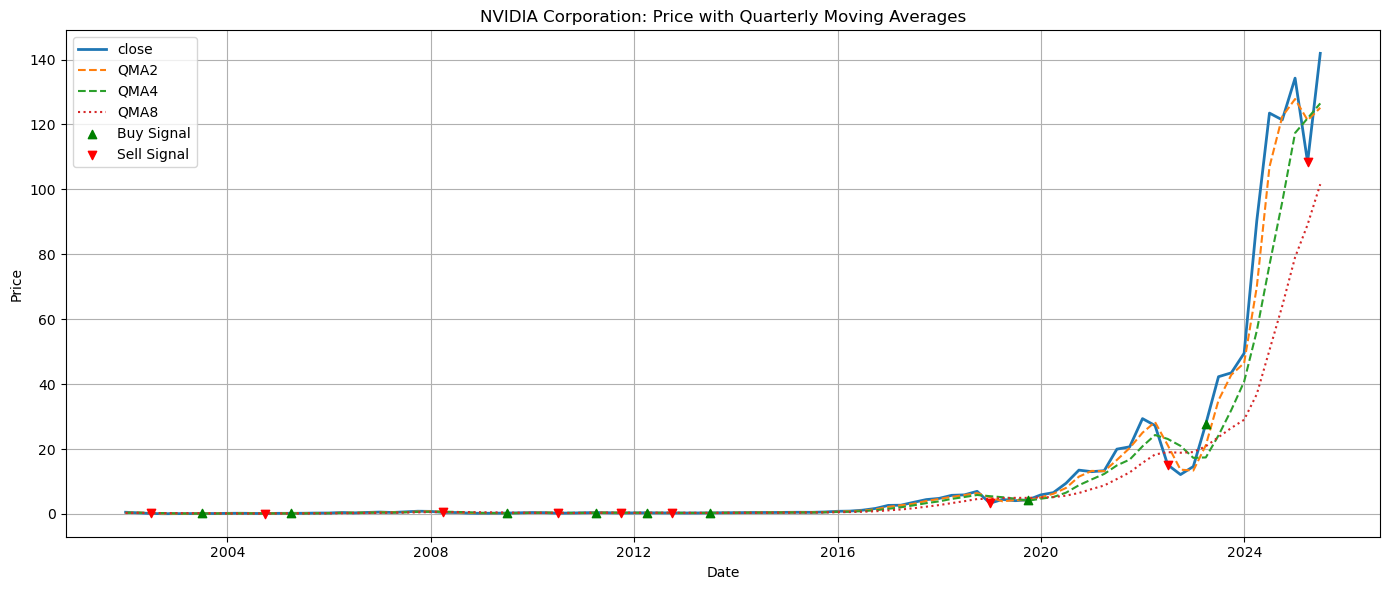

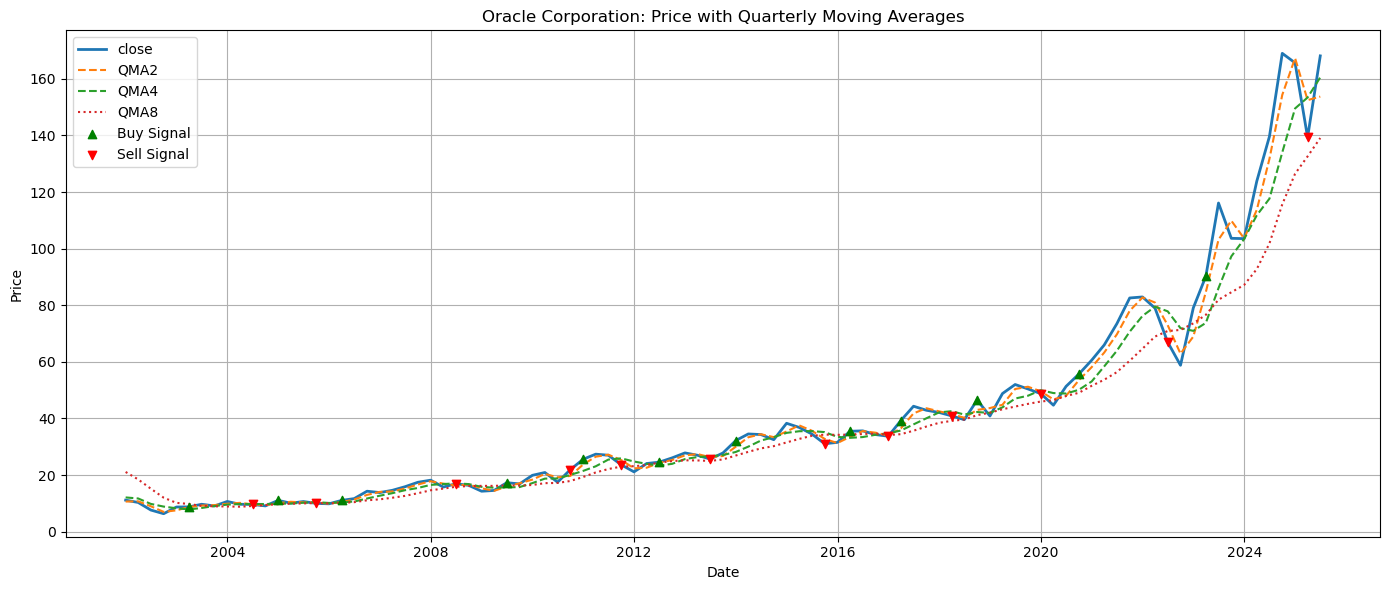

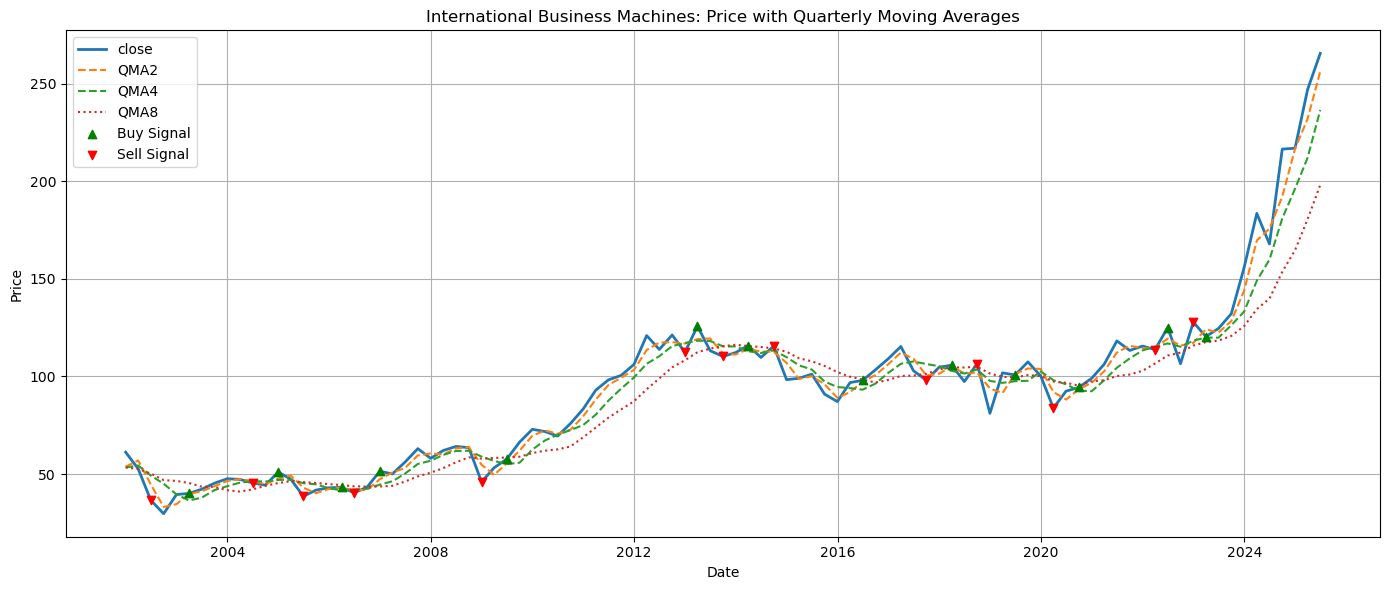

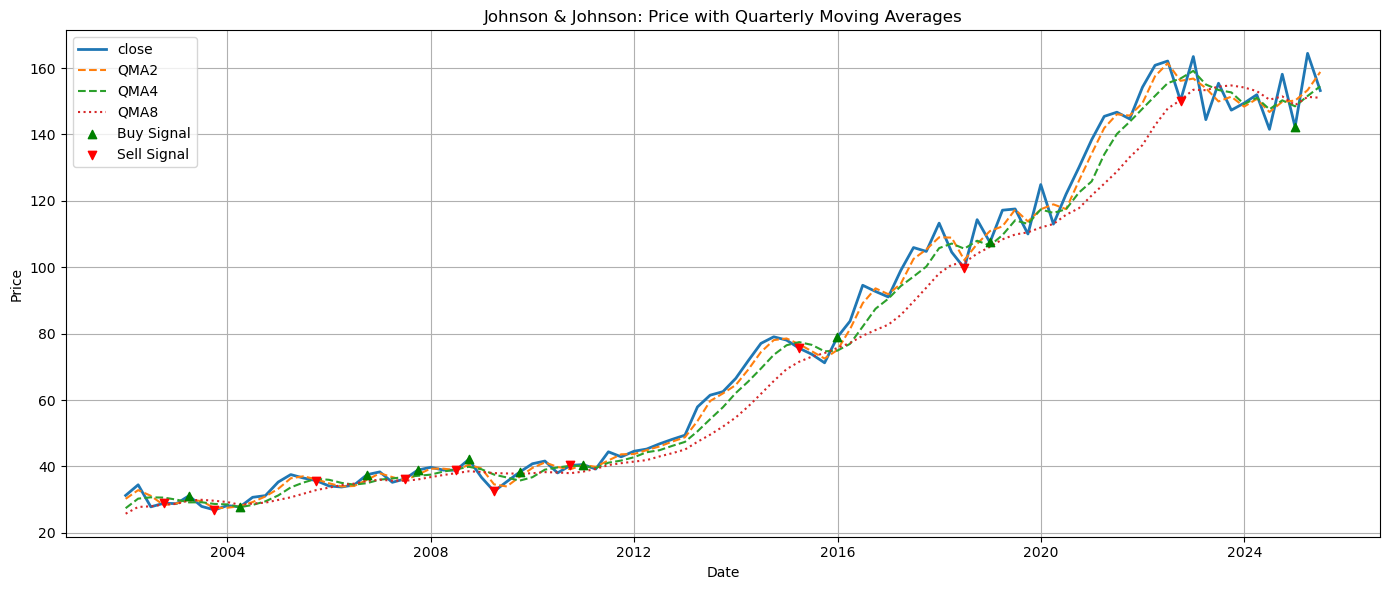

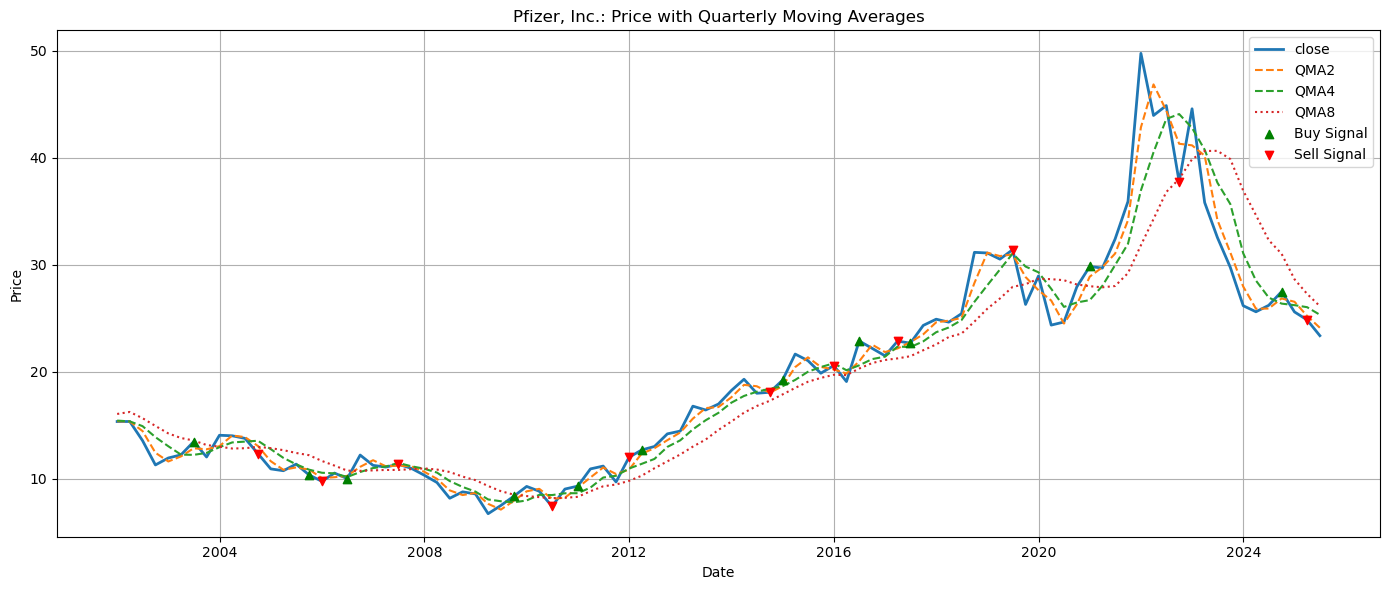

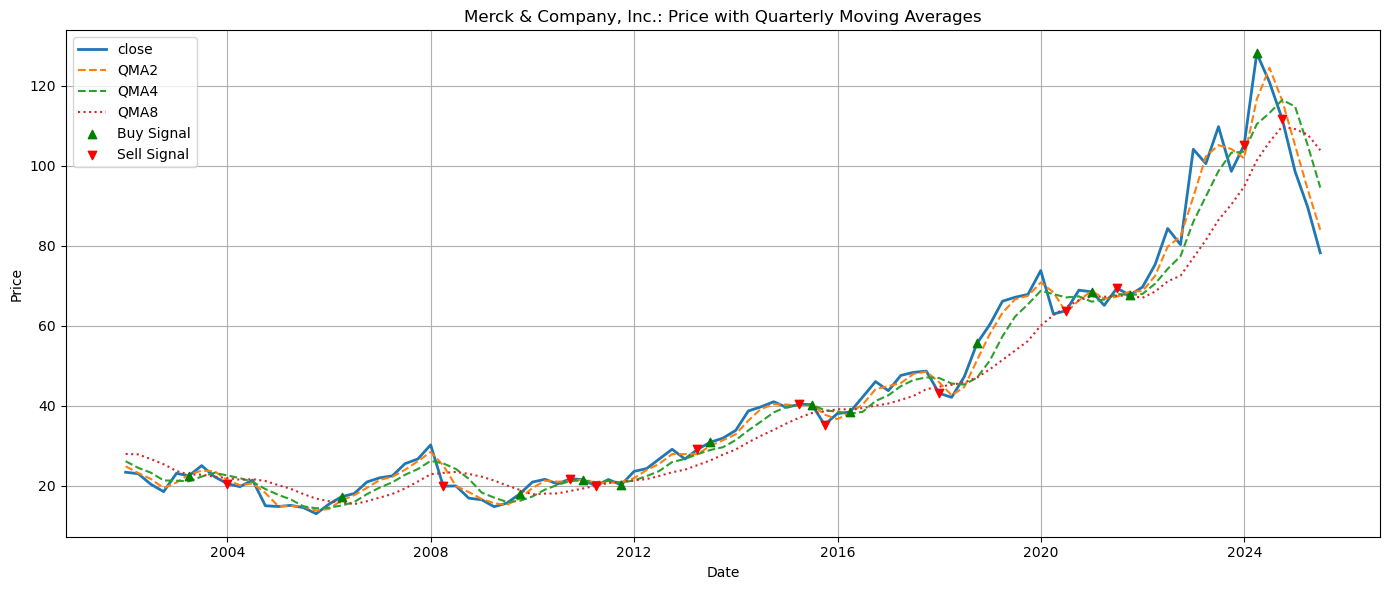

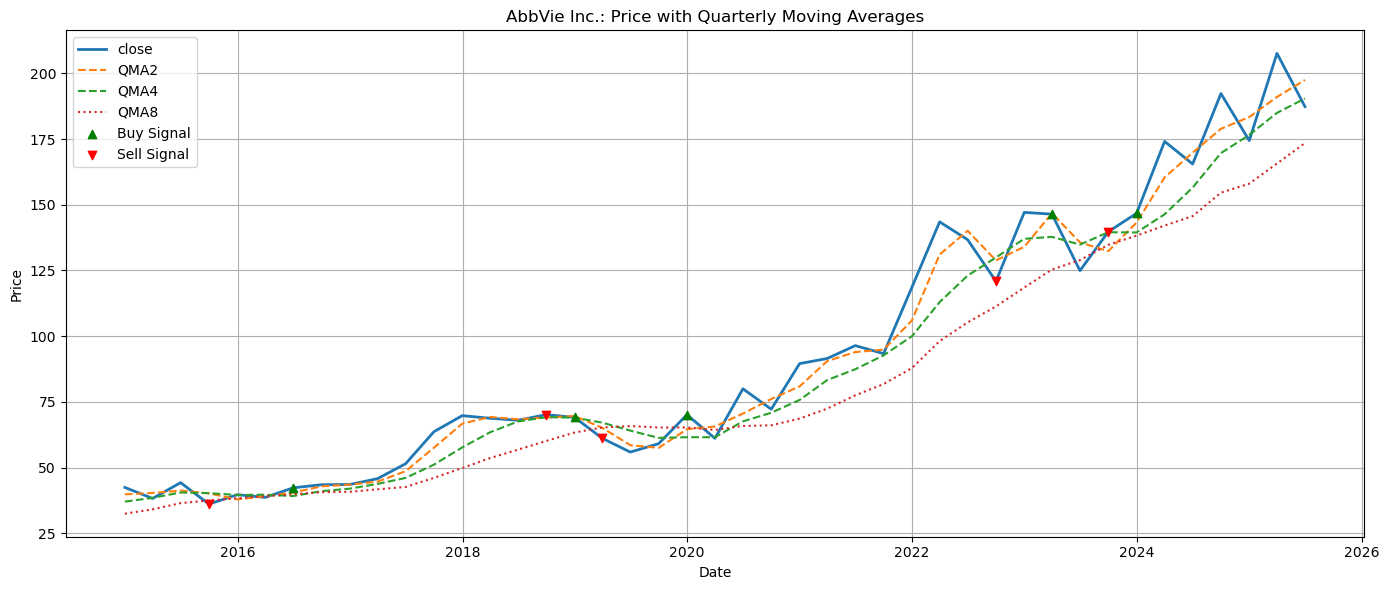

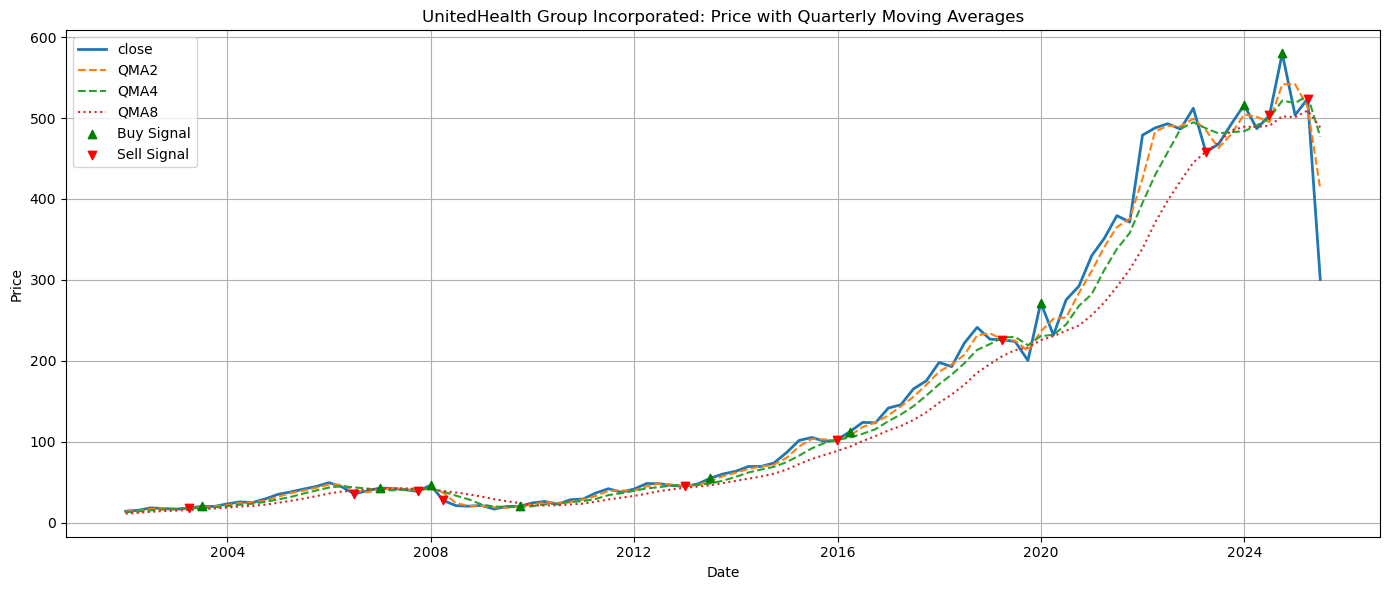

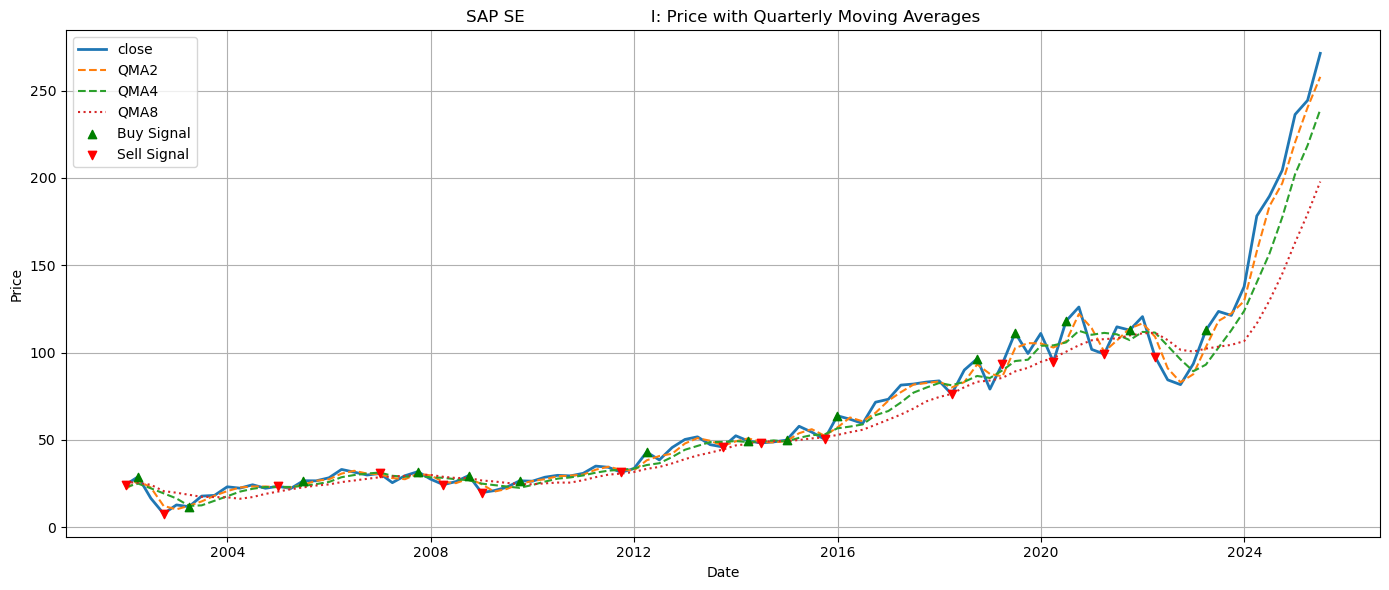

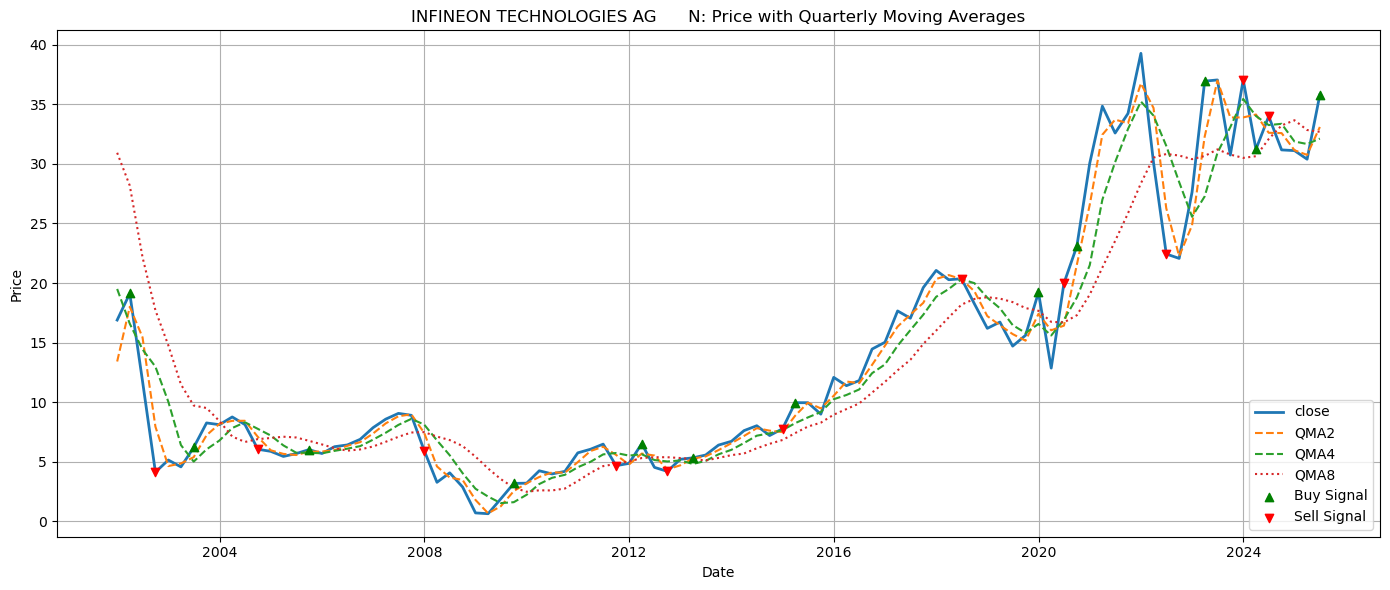

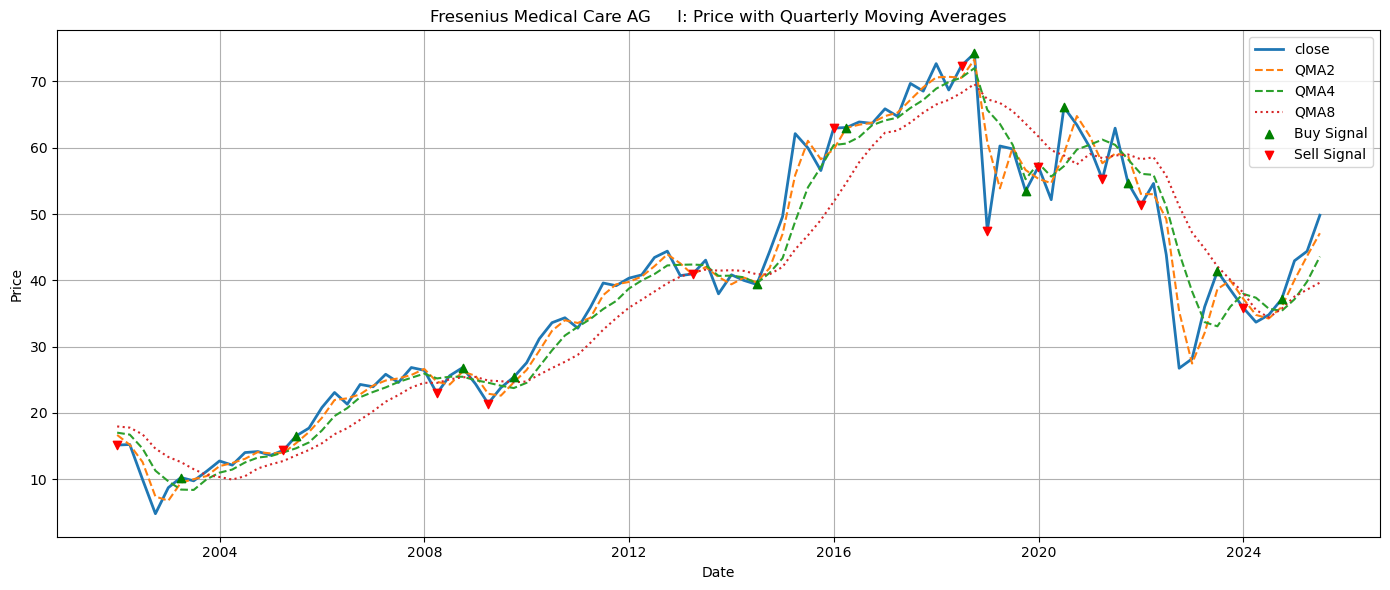

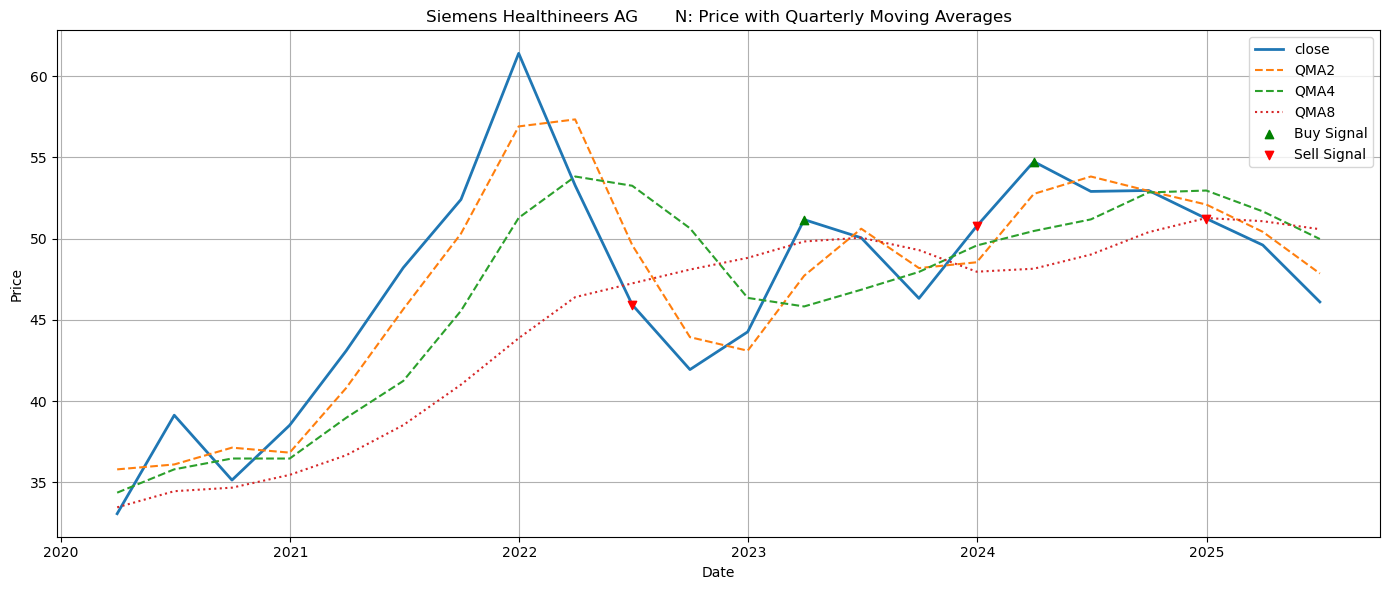

In [233]:
for ticker in df['ticker'].unique():
    plot_price_with_qma_signals(df, ticker)

In [234]:
df.columns

Index(['ticker', 'date', 'year', 'quarter', 'close', 'return_1q', 'return_2q',
       'return_3q', 'vol_3q', 'momentum_3q', 'qma_2', 'qma_4', 'qma_8',
       'buy_signal', 'sell_signal', 'marketCap', 'beta', 'trailingPE',
       'forwardPE', 'trailing_PEG', 'priceToBook', 'dividendYield',
       'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'strong_to_total_reco_ratio',
       'days_to_next_earnings', 'dividend_stability', 'companyName', 'sector',
       'industry', 'country', 'fullTimeEmployees'],
      dtype='object')

In [235]:
#tsla = yf.Ticker('JNJ')

# CALL THE MULTIPLE FUNCTIONS AVAILABLE AND STORE THEM IN VARIABLES.
#actions = tsla.get_actions()
#analysis = tsla.get_analysis()
#balance = tsla.get_balance_sheet()
#calendar = tsla.get_calendar()
#cf = tsla.get_cashflow()
#info = tsla.get_info()
#inst_holders = tsla.get_institutional_holders()
#news = tsla.get_news()
#recommendations = tsla.get_recommendations()
#sustainability = tsla.get_sustainability()


#info#.index